# Braden-Scaling IQNx4: 1.Mass (UNDER CONSTRUCTION!)

# Do `source setup.sh` before trying to run this notebook!



## External Imports

If you don't have some of these packages installed, you can also use the conda environment that has all of the packages by doing `conda env create -f IQN_env.yml && conda activate IQN_env`

There is also a `requirements.txt` here so that it can be run on an interactive website, eg binder or people can `pip install` it.

In [10]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
import ipywidgets as wid; 

using torch version 1.9.0
using (optional) optuna version 2.8.0


## Import utils, and set environemnt variables

In [11]:
try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


In [12]:
# os.environ['IQN_BASE']='/home/ali/Desktop/Pulled_Github_Repositories/torchQN'
# os.environ['DATA_DIR']='/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/data'

### A user is competent enought to do `source setup.sh` on a `setup.sh` script that comes in the repo, such as the next cell uncommented

In [13]:
# %%writefile setup.sh
# #!/bin/bash
# export IQN_BASE=/home/ali/Desktop/Pulled_Github_Repositories/torchQN
# #DAVIDSON
# #export DATA_DIR='/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/data'
# #LOCAL
# export DATA_DIR='/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data'
# echo 'DATA DIR'
# ls -l $DATA_DIR
# #ln -s $DATA_DIR $IQN_BASE, if you want
# #conda create env -n torch_env -f torch_env.yml
# #conda activate torch_env
# mkdir -p ${IQN_BASE}/images/loss_plots ${IQN_BASE}/trained_models  ${IQN_BASE}/hyperparameters ${IQN_BASE}/predicted_data
# tree $IQN_BASE

Plotting and image functions

In [14]:
def show_jupyter_image(image_filename, width = 1300, height = 300):
    """Show a saved image directly in jupyter. Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(IQN_BASE,image_filename), width = width, height = height  ))
    
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter (better quality)"""
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')

def reset_plt_params():
    """reset matplotlib parameters - often useful"""
    use_svg_display()
    mpl.rcParams.update(mpl.rcParamsDefault)

def show_plot(legend=False):
    use_svg_display()
    plt.tight_layout();
    plt.show()
    if legend:
        plt.legend(loc='best')
        
def set_figsize(get_axes=False,figsize=(7, 7)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    if get_axes:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        return fig, ax
    
def set_axes(ax, xlabel, ylabel=None, xmin=None, xmax=None, ymin=None, ymax=None, title=None):
    """saves a lot of time in explicitly difining each axis, its title and labels: do them all in one go"""
    use_svg_display()
    ax.set_xlabel(xlabel,fontsize=font_axes)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=font_axes)
    if xmin and xmax:
        ax.set_xlim(xmin, xmax)
    
    if ax.get_title()  != '':
        #if the axes (plot) does have a title (which is non-empty string), display it 
        ax.set_title(title)
    if ax.legend():
        #if an axis has a legned label, display it
        ax.legend(loc='best',fontsize=font_legend)
    if ymin and ymax:
        #sometimes we dont have ylimits since we do a lot of histograms, but if an axis has ylimits, set them
        ax.set_ylim(ymin, ymax)
    
    try:
        fig.show()
    except Exception:
        pass
    plt.tight_layout()
    plt.show()

# Results prior to Braden-scaling

Recall that the best IQNx4 autoregressive results that I attained prior to trying the Braden scaling was the following (which was implemented in the Davidson cluster here: `/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/OCT_7/*.py` and copied to my repo [here](https://github.com/AliAlkadhim/torchQN/tree/master/OCT_7) )


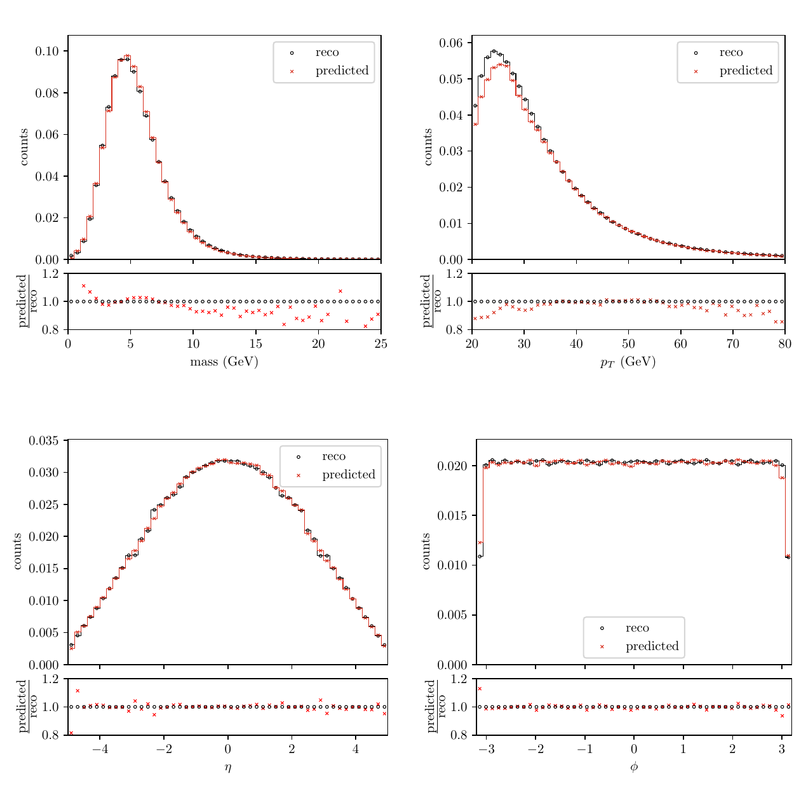

In [15]:
show_jupyter_image('OCT_7/AUTOREGRESSIVE_RESULTS_OCT7.png',width = 800, height = 200)

So we know IQNx4 works (but not perfect enough), but in this notebook we try the Braden scaling (first time trying this scaling) to see if we can do better.

In [16]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:
wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

## Set arguments and configurations

In [17]:
################################### ARGUMENTS ###################################
parser=argparse.ArgumentParser(description='train for different targets')
parser.add_argument('--N', type=str, help='''size of the dataset you want to use. 
                    Options are 10M and 100K and 10M_2, the default is 10M_2''', required=False,default='10M_2')
#N_epochs X N_train_examples = N_iterations X batch_size
# N_iterations = (N_epochs * train_data.shape[0])/batch_size
#N_iterations = (N_epochs * train_data.shape[0])/64 = 125000 for 1 epoch
parser.add_argument('--n_iterations', type=int, help='''The number of iterations for training, 
                    the default is''', required=False,default=50)
#default=5000000 )
parser.add_argument('--n_layers', type=int, help='''The number of layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--n_hidden', type=int, help='''The number of hidden layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--starting_learning_rate', type=float, help='''Starting learning rate, 
                    the defulat is 10^-3''', required=False,default=1.e-2)
parser.add_argument('--show_loss_plots', type=bool, help='''Boolean to show the loss plots, 
                    default is False''', required=False,default=False)
parser.add_argument('--save_model', type=bool, help='''Boolean to save the trained model dictionary''', 
                    required=False,default=False)
parser.add_argument('--save_loss_plots', type=bool, help='''Boolean to save the loss plots''', 
                    required=False,default=False)


################################### CONFIGURATIONS ###################################
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True
SUBSAMPLE=int(1e5)#subsample use for development - in production use whole dataset

if JUPYTER:
    args = parser.parse_args(args=[])
    N = '10M_2'
    n_iterations = int(1e4)
    n_layers, n_hidden = int(1), int(10)
    starting_learning_rate = float(1.e-2)
    show_loss_plots = False
    save_model=False
    save_loss_plots = False
else:
    args = parser.parse_args()
    N = args.N
    n_iterations = args.n_iterations
    n_layers = args.n_layers
    n_hidden = args.n_hidden
    starting_learning_rate=args.starting_learning_rate
    show_loss_plots=args.show_loss_plots
    save_model=args.save_model
    save_loss_plots=args.save_loss_plots

dropout=0.2

def get_model_params():
    return n_iterations, n_layers, n_hidden, starting_learning_rate, dropout

### Import the numpy data, convert to dataframe and save (if you haven't saved the dataframes)

# Explore the Dataframe and preprocess

another flowchart for how IQN works autoregressively to get $p_T'$, etc

# Data

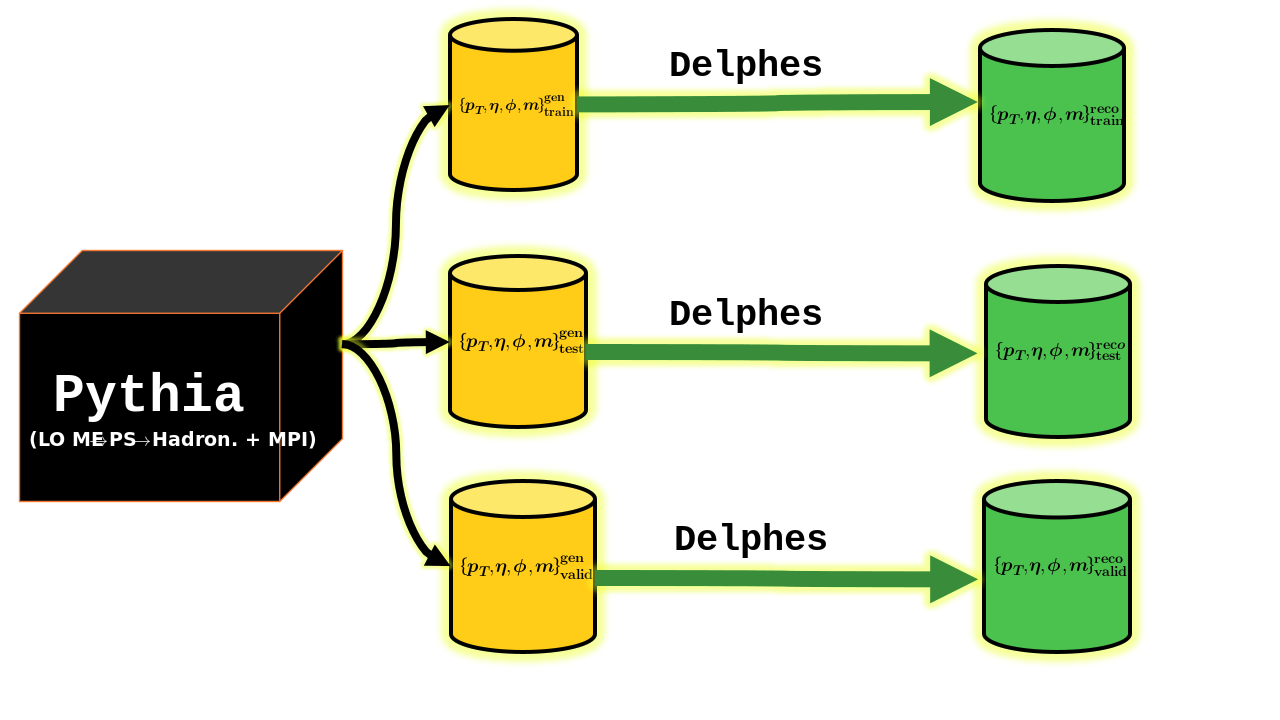

In [18]:
use_svg_display()
show_jupyter_image('images/pythia_ppt_diagram.png', width=2000,height=500)

In [19]:
###############################################################################################
y_label_dict ={'RecoDatapT':'$p(p_T)$'+' [ GeV'+'$^{-1} $'+']',
                    'RecoDataeta':'$p(\eta)$', 'RecoDataphi':'$p(\phi)$',
                    'RecoDatam':'$p(m)$'+' [ GeV'+'$^{-1} $'+']'}

loss_y_label_dict ={'RecoDatapT':'$p_T^{reco}$',
                    'RecoDataeta':'$\eta^{reco}$', 'RecoDataphi':'$\phi^{reco}$',
                    'RecoDatam':'$m^{reco}$'}

<!-- For Davidson team, please read try to all the code/comments before asking me questions! -->

Decide on an evaluation order 

In [20]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

#set order of training:
#pT_first: pT->>m->eta->phi
#m_first: m->pT->eta->phi

ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                               'xmin': 0, 
                               'xmax': 25},

               'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                               'xmin'  : 20, 
                               'xmax'  :  80},

               'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                               'xlabel': r'$\eta$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                               'xlabel': r'$\phi$' ,
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }

Load and explore raw (unscaled) dataframes

In [21]:
all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
################################### Load unscaled dataframes ###################################
raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )

In [22]:
def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(15,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()

['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']
Reco_var:  RecoDatapT , 	 gen_var:  genDatapT
Reco_var:  RecoDataeta , 	 gen_var:  genDataeta
Reco_var:  RecoDataphi , 	 gen_var:  genDataphi
Reco_var:  RecoDatam , 	 gen_var:  genDatam


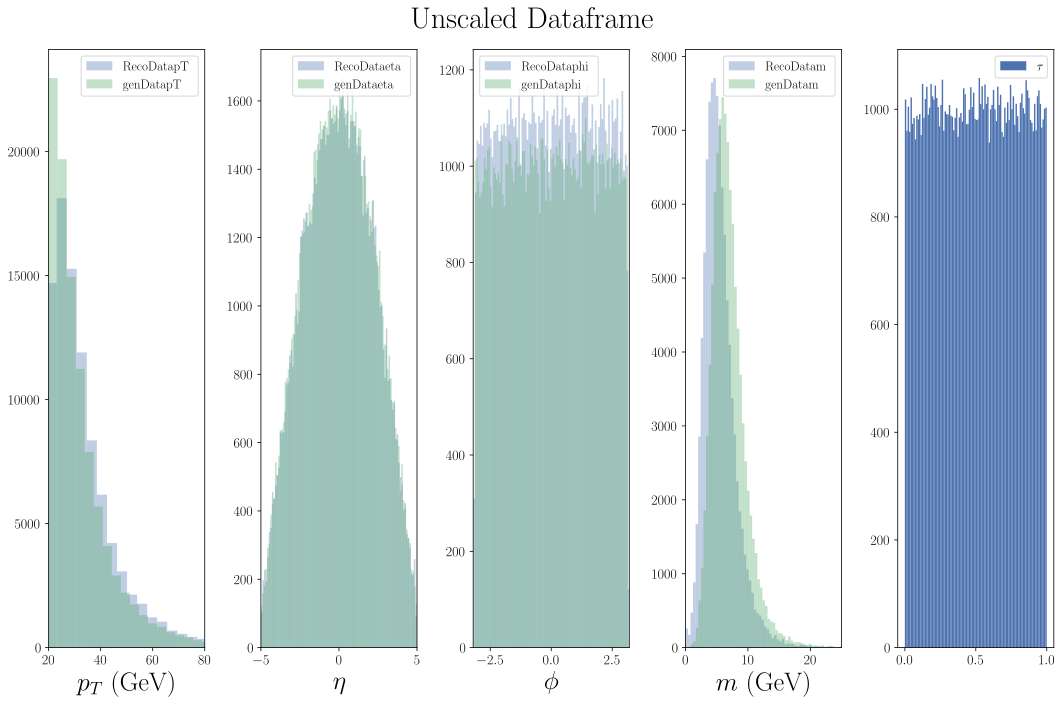

In [23]:
explore_data(df=raw_train_data, title='Unscaled Dataframe')

In [24]:
print(raw_train_data.shape)
raw_train_data.describe()#unscaled

(100000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,32.839817,0.002209,0.007407,6.989531,32.967169,0.002216,0.007274,5.565402,0.500433
std,14.903975,2.216944,1.808915,2.789053,15.779735,2.210441,1.809601,2.685486,0.288280
min,20.000100,-5.123860,-3.141590,-0.000008,11.488700,-4.997590,-3.401475,-0.000031,0.000004
25%,23.799875,-1.664598,-1.556332,5.131500,23.487200,-1.663780,-1.556070,3.796510,0.250173
50%,28.525150,0.012869,0.014945,6.555895,29.070900,0.010939,0.017256,5.123870,0.501250
75%,36.476800,1.669738,1.568370,8.309520,37.664450,1.668075,1.564928,6.781140,0.749984
max,367.110000,5.118850,3.141550,41.075900,397.992000,4.998390,3.428875,40.567400,0.999995


In [25]:
print(raw_test_data.shape)
raw_test_data.describe()#unscaled

(100000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,32.789973,0.006608,0.008208,6.999333,32.911578,0.006592,0.008088,5.567205,0.501150
std,15.384256,2.202526,1.813943,2.848071,15.987607,2.196239,1.814262,2.675589,0.288991
min,20.000500,-5.129500,-3.141580,-0.000043,11.475300,-4.995010,-3.451545,-0.000037,0.000013
25%,23.746000,-1.644760,-1.568913,5.129663,23.492925,-1.638462,-1.567520,3.811640,0.250567
50%,28.415000,0.022204,0.007787,6.555330,29.040850,0.024047,0.008805,5.129005,0.501971
75%,36.405900,1.652347,1.581260,8.317600,37.637800,1.648130,1.581675,6.785560,0.752653
max,414.323000,5.085910,3.141460,71.779900,399.330000,4.994290,3.462845,70.626900,0.999996


In [26]:
# np.array(train_data['genDatapT'])

# Scaling

scaling (or standarization, normalization) is someimes done in the following way:
$$ X' = \frac{X-X_{min}}{X_{max}-X_{min}} \qquad \rightarrow \qquad X= X' (X_{max}-X_{min}) + X_{min}$$

In [27]:
# def standarize(values):
#     expected_min, expected_max = values.min(), values.max()
#     scale_factor = expected_max - expected_min
#     offset = expected_min
#     standarized_values = (values - offset)/scale_factor 
#     return standarized_values

Or by taking z-score:

$$ X'=z(X)=\frac{X-E[X]}{\sigma_{X}}  \qquad \rightarrow \qquad X = z^{-1}(X')= X' \sigma_{X} + E[X].$$


# Braden scaling 

In the IQN-scipost overleaf, we say the scaling is the following:

$$\mathbb{T}(p_T) = z(\log p_T), \qquad \mathbb{T}(\eta) = z(\eta), \qquad \mathbb{T}(\phi) = z(\phi), \qquad \mathbb{T}(m) = z(\log (m + 2))$$ 

$$ \mathbb{T}(\tau) = 6\tau - 3 $$


Which means, for a jet observable $\mathcal{O}$ (or quantile $\tau$), the Braden-scaling perscribes that the data is first scaled according to:

$$
\begin{align}
    \mathbb{L} (\mathcal{O}) &=
    \begin{cases}
        z \left( \log{\mathcal{O}} \right), \qquad & \text{if } \mathcal{O}= p_T \\
        z \left(\mathcal{O} \right), \qquad & \text{if } \mathcal{O}=\eta \\
        z \left( \log (\mathcal{O} + 2) \right), \qquad & \text{if } \mathcal{O}=m \\
        z \left( \mathcal{O} \right), \qquad & \text{if } \mathcal{O}=\phi \\
        z \left( 6 \mathcal{O} -3 \right), \qquad & \text{if } \mathcal{O}=\tau
    \end{cases}
\end{align}
$$

We also say we use the following as targets

$$
z\left(\frac{y_n + 10}{x_n + 10}\right), \qquad n = 1,\cdots,4,
\label{eq:normalization}
$$

We mean that the predicted target for a desired reco observable $\mathcal{O}$ is chosen to be the following function

$$
    \mathbb{T}(\mathcal{O}) = z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$

where for a random variable $x$, $z$ is the standardization function (z-score):

$$
   x'= z (x) \equiv \frac{x-\bar{x}}{\sigma_{x}} \ .
$$

Such that its inverse is 

$$ z^{-1}(x') = x' \ \sigma_x + \bar{x} $$

If we do this on the data, after training, the NN $f_{\text{IQN}}$ will not estimate the observable, 

$$\mathcal{O}^{\text{predicted}} \ne \mathcal{O}^{\text{reco}}$$

but will instead estimate 

$$
        f_{\text{IQN}} (\mathcal{O}) \approx  z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$

which needs to be de-scaled (when evaluated on the data that which has been scaled according to 

$$\mathbb{T}(\text{evaluation data}) = z \left( \frac{\mathbb{L} (\text{data}^{\text{reco}}) +10 }{\mathbb{L}(\text{data}^{\text{gen}}) +10} \right) $$


in order to copare with $\mathcal{O}$ directly.) The descaling for $\mathcal{O}=p_T$ (as an example) would be:

$$
    p_T^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (p_T^\text{gen})+10 \right] -10 \right]
$$


-----------

## Basically a "standard scaling procedure" is the following (background):

1. Split the data into train and test dataframes
2. fit the scaler on each of the train and test sets independently, that is, get the mean and std, ( optionally and min and max or other quantities) of each feature (column) of each of the train and test dataframes, independently.
3. transform each of the train and test sets independently. That is, use the means and stds of each column to transform a column $X$ into a column $X'$ e.g. according to 
$$ X'=z(X)= \frac{X-E[X]}{\sigma_{X}}$$
4. Train NN on transformed features $X_{train}'$ (and target $y_{train}'$) (in train df, but validate on test set, which will not influence the weights of NN ( just used for observation that it doesnt overfit) )
5. Once the training is done, *evaluate the NN on transformed features of the test set* $X_{test}'$, i.e. do $NN(X_{test}')$, which will result in a scaled prediction of the target $y_{pred}'$
6. Unscale the $y_{pred}'$, i.e. apply the inverse of the scaling operation, e.g.
$$ y_{pred}=z^{-1}(y_{pred}')= y_{pred}' \sigma_{y} + E[y]$$,
where 

$$\sigma{y}$$

and 

$$E[y]$$

are attained from the test set *prior to training and scaling*.

7. Compare to $y$ (the actual distribution you're trying to estimate) one-to-one

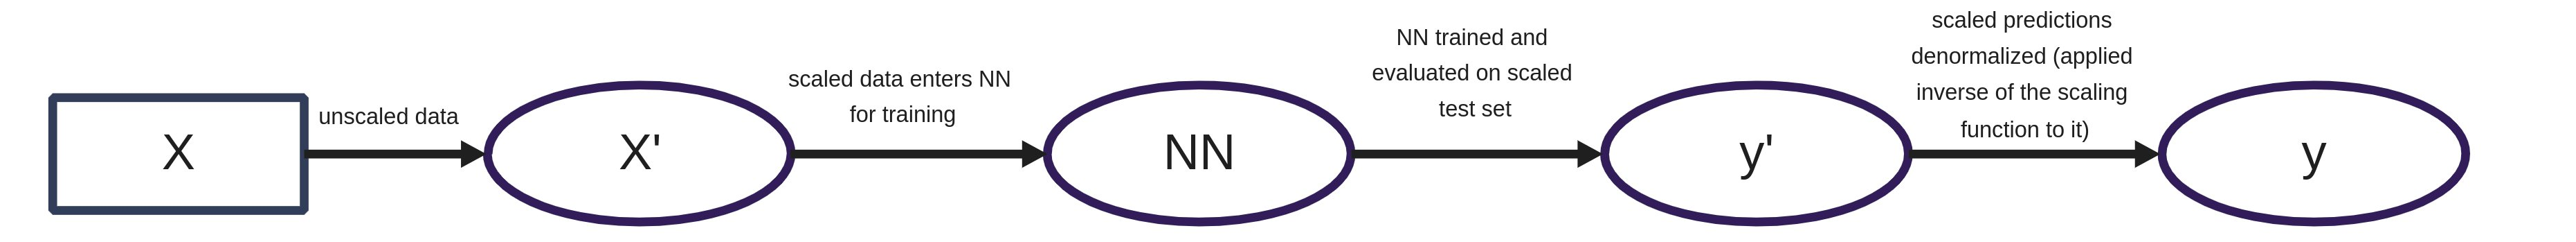

In [28]:
use_svg_display()
show_jupyter_image('images/scaling_forNN.jpg', width=2000,height=500)


## Scale the data accoding to the "Braden Kronheim scaling" :


In [29]:
def z(x):
    eps=1e-20
    return (x - np.mean(x))/(np.std(x)+ eps)
def z_inverse(xprime, x):
    return xprime * np.std(x) + np.mean(x)

In [30]:
def get_scaling_info(df):
    """args: df is train or eval df.
    returns: dictionary with mean of std of each feature (column) in the df"""
    features=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam',
              'RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
    SCALE_DICT = dict.fromkeys(features)
    for i in range(8):
        feature = features[i]
        feature_values = np.array(df[feature])
        SCALE_DICT[feature]={}
        SCALE_DICT[feature]['mean'] = np.mean(feature_values)
        SCALE_DICT[feature]['std'] = np.std(feature_values)
    return SCALE_DICT

In [31]:
TRAIN_SCALE_DICT = get_scaling_info(raw_train_data);print(TRAIN_SCALE_DICT)
print('\n\n')
TEST_SCALE_DICT = get_scaling_info(raw_test_data);print(TEST_SCALE_DICT)

{'genDatapT': {'mean': 32.83981673500001, 'std': 14.90390068970772}, 'genDataeta': {'mean': 0.0022088420911595004, 'std': 2.2169332378187043}, 'genDataphi': {'mean': 0.007407000418604001, 'std': 1.8089060619308075}, 'genDatam': {'mean': 6.989531155823706, 'std': 2.7890394898296575}, 'RecoDatapT': {'mean': 32.967168834000006, 'std': 15.77965621193832}, 'RecoDataeta': {'mean': 0.0022161224001759983, 'std': 2.210429783644192}, 'RecoDataphi': {'mean': 0.007273818861474919, 'std': 1.8095924300645279}, 'RecoDatam': {'mean': 5.56540205907344, 'std': 2.685472287815592}, 'tau': None}



{'genDatapT': {'mean': 32.789972774, 'std': 15.384179205005177}, 'genDataeta': {'mean': 0.006608154498524002, 'std': 2.2025154076148628}, 'genDataphi': {'mean': 0.008208394428199, 'std': 1.8139342621996013}, 'genDatam': {'mean': 6.999332512503679, 'std': 2.84805626718976}, 'RecoDatapT': {'mean': 32.911577552999994, 'std': 15.987527551904504}, 'RecoDataeta': {'mean': 0.006592317058908998, 'std': 2.196228419636194

In [32]:
def L(orig_observable, label):
    eps=1e-20
    orig_observable=orig_observable+eps
    if label=='pT':
        const=0
        log_pT_=np.log(orig_observable) 
        L_observable = log_pT_
    if label=='eta':
        const=0
        L_observable=orig_observable
    if label=='m':
        const=2
        L_observable=np.log(orig_observable + const)
    if label=='phi':
        L_observable=orig_observable
    if label=='tau':
        L_observable = (6*orig_observable) - 3
    
    return L_observable.to_numpy()

In [33]:
def L_inverse(L_observable, label):
    eps=1e-20
    L_observable=L_observable+eps
    if label=='pT':
        const=0
        L_inverse_observable = np.exp(L_observable)
    if label=='eta':
        L_inverse_observable = L_observable
    if label=='m':
        const=2
        L_inverse_observable = np.exp(L_observable) - const
    if label=='tau':
        L_inverse_observable = (L_observable+3)/6
        
    if not isinstance(L_inverse_observable, np.ndarray):
        L_inverse_observable = L_inverse_observable.to_numpy()
    return L_inverse_observable

In [34]:
def T(variable, scaled_df):
    if variable=='pT':
        L_pT_gen=scaled_df['genDatapT']
        L_pT_reco = scaled_df['RecoDatapT']
        target = z( (L_pT_reco+10)/(L_pT_gen+10) )
    if variable=='eta':
        L_eta_gen=scaled_df['genDataeta']
        L_eta_reco = scaled_df['RecoDataeta']
        target = z( (L_eta_reco+10)/(L_eta_gen+10) )
    if variable=='phi':
        L_phi_gen=scaled_df['genDataphi']
        L_phi_reco = scaled_df['RecoDataphi']
        target = z( (L_phi_reco+10)/(L_phi_gen+10) )
    if variable=='m':
        L_m_gen=scaled_df['genDatam']
        L_m_reco = scaled_df['RecoDatam']
        target = z( (L_m_reco+10)/(L_m_gen+10) )
    
    return target

In [35]:
def L_scale_df(df, title, save=False):
    #scale
    # SUBSAMPLE=int(1e6)
    df = df[all_cols]#[:SUBSAMPLE]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = L(df.iloc[:,0], label='pT')
    scaled_df['RecoDatapT'] = L(df.iloc[:,4], label='pT')
    
    scaled_df['genDataeta'] = L(df.iloc[:,1], label='eta')
    scaled_df['RecoDataeta'] = L(df.iloc[:,5],label='eta')
    
    
    scaled_df['genDataphi'] = L(df.iloc[:,2],label='phi')
    scaled_df['RecoDataphi'] = L(df.iloc[:,6],label='phi')

    scaled_df['genDatam'] = L(df.iloc[:,3],label='m')
    scaled_df['RecoDatam'] = L(df.iloc[:,7],label='m')
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = L(df.iloc[:,8],label='tau')
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df

           genDatapT     RecoDatapT     genDataeta    RecoDataeta  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        3.424985       3.414709       0.002209       0.002216   
std         0.337133       0.381547       2.216944       2.210441   
min         2.995737       2.441364      -5.123860      -4.997590   
25%         3.169680       3.156456      -1.664598      -1.663780   
50%         3.350786       3.369738       0.012869       0.010939   
75%         3.596676       3.628717       1.669738       1.668075   
max         5.905662       5.986432       5.118850       4.998390   

          genDataphi    RecoDataphi       genDatam      RecoDatam  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.007407       0.007274       2.153485       1.968469   
std         1.808915       1.809601       0.287997       0.328800   
min        -3.141590      -3.401475       0.693143       0.693132   
25%        -1.556332      -1.5560

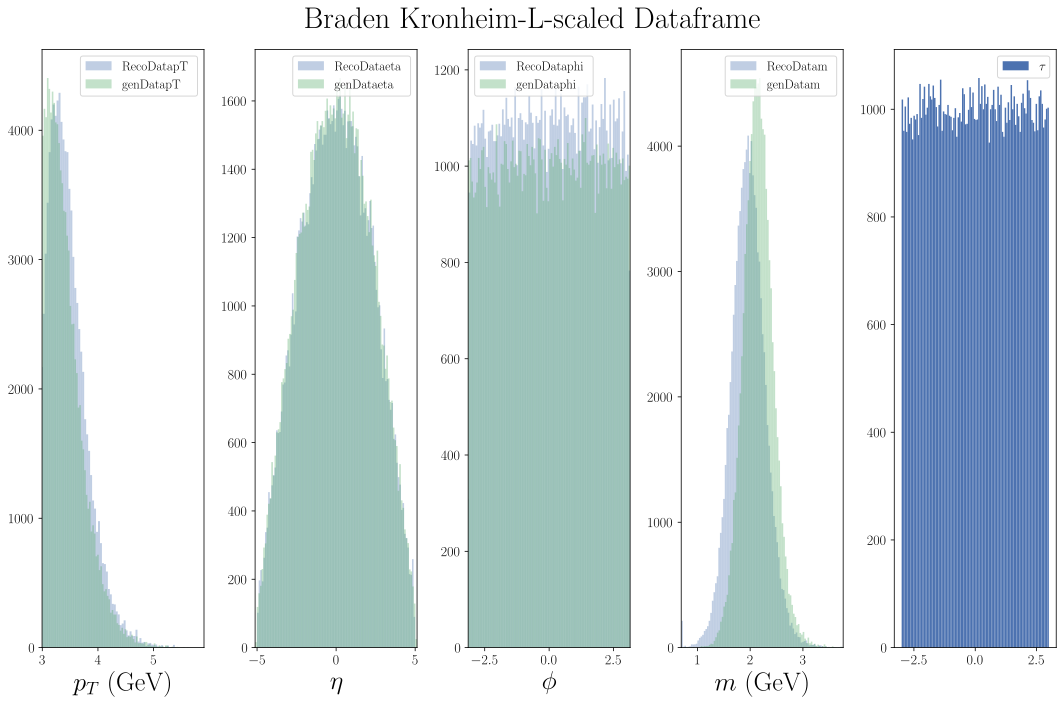

In [36]:
scaled_train_data = L_scale_df(raw_train_data, title='scaled_train_data_10M_2.csv',
                             save=True)
print('\n\n')
scaled_test_data = L_scale_df(raw_test_data,  title='scaled_test_data_10M_2.csv',
                            save=True)

explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

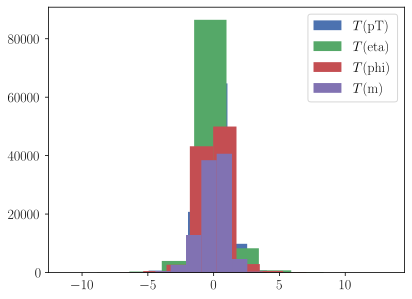

In [37]:
labels = ['pT', 'eta','phi','m']
for label in labels:
    target = T(label, scaled_df=scaled_train_data)
    plt.hist(target, label = '$T($' +label+ '$)$' )
# target_pT = T('pT', scaled_df=scaled_train_data)
# target_eta = T('eta', scaled_df=scaled_train_data)
# target_phi = T('phi', scaled_df=scaled_train_data)
# target_m = T('m', scaled_df=scaled_train_data)
# plt.hist(target_pT, label='$T(p_T)$')

plt.legend();plt.show()

In [38]:
# scaled_train_data = L_scale_df(train_data, title='scaled_train_data_10M_2.csv',
#                              save=True)
# print('\n\n')
# scaled_test_data = L_scale_df(test_data,  title='scaled_test_data_10M_2.csv',
#                             save=True)

# explore_data(df=scaled_train_data, title='Braden Kronheim-$L$-scaled Dataframe: standarize_IQN', scaled=True)

---------
------
# ML

Note that this ideas is very powerful and has the potential to replace the use of Delphes/GEANT for most people. According to the [previous paper](https://arxiv.org/pdf/2111.11415.pdf) this method already works for a single IQN.

It's important to remember "the master formula" of all of machine learning:

$$\int \frac{\partial L}{\partial f} p(y|x) dy  = 0 \tag{1}$$

or, equivalently, 

$$ \frac{\delta R}{\delta f}=0,$$

where $L$ is the loss function, $f$ is the model (in this case IQN) (implicitly parameterized by potentially a  gazillion parameters), $y$ is the target(s) that we want to estimate, $x$ is the (set of) training features, $R$ is the risk functional:

$$ R[f] = \int \cdots \int \, p(t, \mathbf{x}) \, L(f(\mathbf{x}, \theta), y) \, dy \, d\mathbf{x}$$


So, for IQNs,

$$ L_{\text{IQN}}(f, y)=\left\{\begin{array}{ll}
\tau(y-f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})) & y \geq f(\boldsymbol{x}, \tau ; \boldsymbol{\theta}) \\
(1-\tau)(f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})-y) & y<f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})
\end{array},\right.$$

Means that what was done previously is that the risk functional, which could be a functional of many models $f$, was a only a functional of a single model: $R[f_1,..., f_n] = R[f_1]$. Here we have 4 models 

$$R_{\text{IQN}x4} =R_{\text{IQN}}[f_m, f_{p_T}, f_\eta, f_\phi], $$ 

and since we're choosing the evaluation order:

$$
\begin{align}
    p(\mathbf{y} | \mathbf{x}) & = 
    p(m'|\mathbf{x} )\nonumber\\
    & \times p(p_T'|\mathbf{x}, m' )\nonumber\\
    & \times p(\eta'| \mathbf{x}, m', p_T' )\nonumber\\
      & \times p(\phi' |  \mathbf{x}, m', p_T', \eta' ) ,
\end{align}
$$



$$ \begin{align}
R_{\text{IQN}x4} &= \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m})  d \mathbf{x_m} d \mathbf{y_m} \\
&\times \  ... \times \\ 
&\times \int L_\text{IQN} \left( f_\phi (\mathbf{x_\phi},\tau), \mathbf{y_\phi} \right) p(\mathbf{x_\phi, y_\phi})  d \mathbf{x_\phi} d \mathbf{y_\phi}
\end{align}$$

where, again, each model $f_i$ is also dependent on a set of parameters $\theta_i$ (dropped for simplicity).

Our risk functional is minimized for

$$\frac{\delta R_{\text{IQN}x4} }{\delta f_m}=0\tag{5}$$

(which is basically what's done in the training process to get $f_m^{*}$ whose weights/parameters minimize the loss). Suppose we factorize the risk as

$$ R_{\text{IQN}x4}  = R_{\text{IQN}}^m \ R_{\text{IQN}}^{p_T}  \ R_{\text{IQN}}^\eta \ R_{\text{IQN}}^\phi \tag{6},$$ 

then, by Eq (4),

$$R_{\text{IQN}}^m \equiv \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m,\tau})  d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau},
$$
and by Eq (5)

$$\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0$$


and by Eq (2)

$$
\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0 \tag{7}
$$

>> ...
<br>

Expand Eq (2) in Eq (7) and integrate wrt y over the appropriate limits to see that  $f(\mathbf{x},\mathbf{\tau})$ is the quantile function for $p(\mathbf{y}|\mathbf{x})$, i.e. (I believe) that IQNx4 should work basically exactly.

$$R_{\text{IQN}x4} = [ L \left( f_m( \{ p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}, m^\text{reco} ) $$
# Train Mass

for mass, 

$$\mathbf{y_m}=m_{\text{reco}}$$

and 

$$\mathbf{x_m}=\{p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}.$$


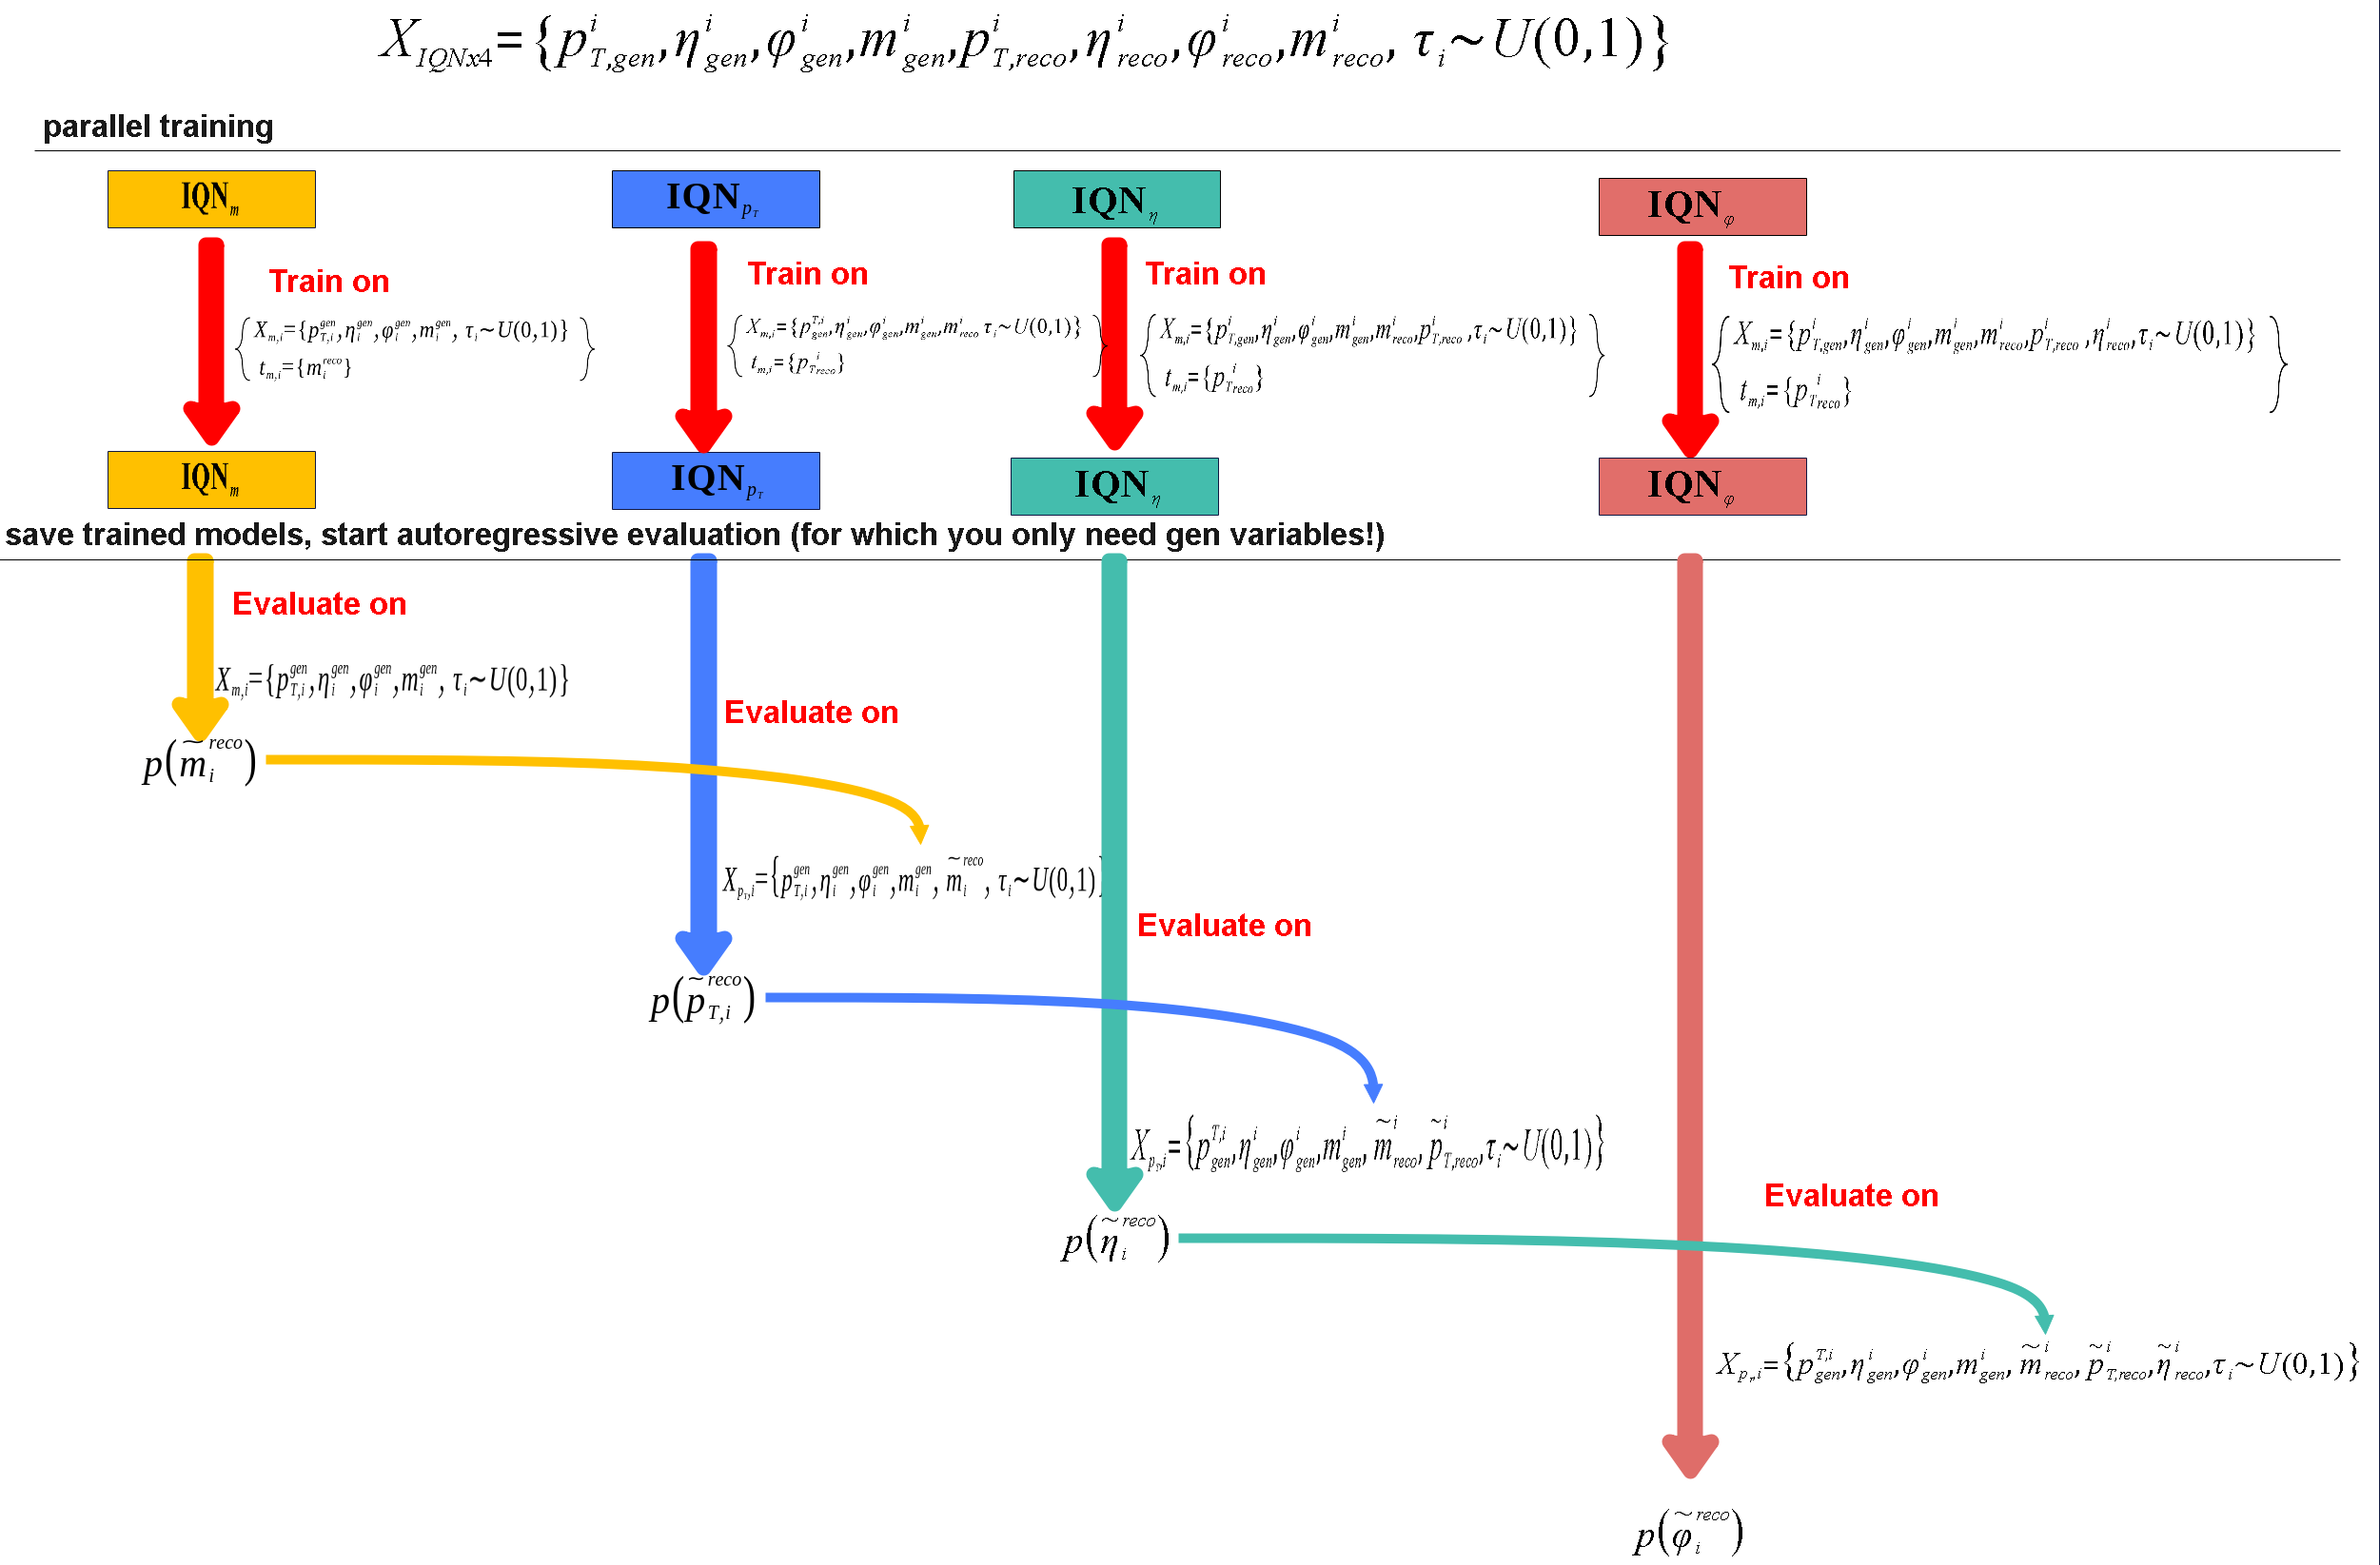

In [39]:
show_jupyter_image('images/IQN_training_flowchart.png',width=3000,height=1000)

### Batches, validation, losses, and plotting of losses functions

In [40]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #Eq (2)
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass


def plot_average_loss(traces, ftsize=18,save_loss_plots=False, show_loss_plots=True):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        filename='IQNx4_%s_Loss.png' % target 
        mkdir('images/loss_plots')
        PATH = os.path.join(IQN_BASE, 'images', 'loss_plots', filename)
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    if show_loss_plots:
        plt.show()

In [41]:
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
########

print('USING NEW DATASET\n')
#UNSCALED
# train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)

# print('TRAINING FEATURES\n', train_data.head())

# test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)
# print('\nTESTING FEATURES\n', test_data.head())
# valid_data= pd.read_csv(os.path.join(DATA_DIR,'valid_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)


# SCALED
train_data_m=pd.read_csv(os.path.join(DATA_DIR,'scaled_train_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

print('TRAINING FEATURES\n', train_data_m.head())

test_data_m= pd.read_csv(os.path.join(DATA_DIR,'scaled_test_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)
print('\nTESTING FEATURES\n', test_data_m.head())

print('\ntrain set shape:',  train_data_m.shape)
print('\ntest set shape:  ', test_data_m.shape)
# print('validation set shape:', valid_data.shape)

USING NEW DATASET

TRAINING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.382531    3.463020    0.828187     0.817082    2.902130     2.919510   
1   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
2   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
3   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
4   3.004211    3.187005    1.844410     1.837910   -0.186685    -0.160621   

   genDatam  RecoDatam       tau  
0  1.579696   1.525158 -0.832143  
1  2.058837   1.995432 -2.238604  
2  2.058837   1.995432  2.773841  
3  2.058837   1.995432 -0.256307  
4  2.040038   1.886115  2.045169  

TESTING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
1   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
2   3.258685    3.313277    3.

### Get training and testing features and targets

In [42]:
def split_t_x(df, target, input_features):
    """ Get teh target as the ratio, according to the T equation"""
    
    if target=='RecoDatam':
        t = T('m', scaled_df=train_data_m)
    if target=='RecoDatapT':
        t = T('pT', scaled_df=train_data_m)
    if target=='RecoDataeta':
        t = T('eta', scaled_df=train_data_m)
    if target=='RecoDataphi':
        t = T('phi', scaled_df=train_data_m)
    x = np.array(df[input_features])
    return np.array(t), x

def normal_split_t_x(df, target, input_features):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x


In [43]:
print(features)
print('\n', target)

['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

 RecoDatam


In [44]:
print(f'spliting data for {target}')
train_t_ratio, train_x = split_t_x(df= train_data_m, target = target, input_features=features)
print('train_t shape = ',train_t_ratio.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t_ratio, valid_x = split_t_x(df= test_data_m, target = target, input_features=features)
print('valid_t shape = ',valid_t_ratio.shape , 'valid_x shape = ', valid_x.shape)

print('no need to train_test_split since we already have the split dataframes')

spliting data for RecoDatam
train_t shape =  (100000,) train_x shape =  (100000, 5)

 Training features:

[[ 3.38253091  0.828187    2.90213     1.57969597 -0.83214275]
 [ 3.19127027 -1.16351     0.636469    2.05883697 -2.23860448]
 [ 3.19127027 -1.16351     0.636469    2.05883697  2.77384086]
 ...
 [ 3.29074988  4.46097     0.381944    2.08581618 -1.14173673]
 [ 3.05937352  4.15091    -2.81233     1.98277782 -2.5718303 ]
 [ 3.54345476  2.1022     -0.435373    1.88054996 -1.85106173]]
valid_t shape =  (100000,) valid_x shape =  (100000, 5)
no need to train_test_split since we already have the split dataframes


In [45]:
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))

[3.42279122 0.00660815 0.00820839 2.15387241 0.00689733] [0.33711058 2.20251541 1.81393426 0.28958123 1.73393965]
[3.42498508e+00 2.20884209e-03 7.40700042e-03 2.15348488e+00
 2.60013681e-03] [0.33713146 2.21693324 1.80890606 0.28799584 1.72966892]


we expect the targets to have mean 0 and variance=1, since theyre the only things standarized

In [46]:
print(valid_t_ratio.mean(), valid_t_ratio.std())
print(train_t_ratio.mean(), train_t_ratio.std())

4.781639262319004e-13 1.0000000000000022
4.781639262319004e-13 1.0000000000000022


Aplly final $z$ to the train and test set features

In [51]:
NFEATURES=train_x.shape[1]
for i in range(NFEATURES):
    train_x[:,i] = z(train_x[:,i])
    valid_x[:,i] = z(valid_x[:,i])
    
print(valid_x.mean(axis=0), valid_x.std(axis=0))

print(train_x.mean(axis=0), train_x.std(axis=0))

[ 3.06243919e-17 -1.56319402e-17 -2.39452902e-17  1.89004368e-17
  2.23820962e-17] [1. 1. 1. 1. 1.]
[ 1.57740487e-17  2.41584530e-18  9.59232693e-18  1.05160325e-17
 -1.43529633e-17] [1. 1. 1. 1. 1.]


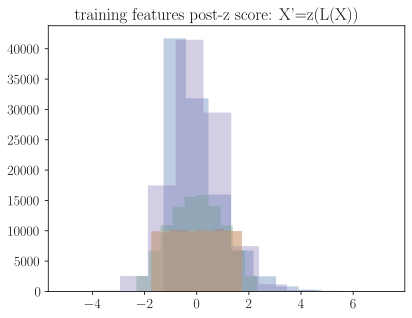

In [52]:
for i in range(NFEATURES):
    plt.hist(train_x[:,i], alpha=0.35)
    plt.title("training features post-z score: X'=z(L(X))")
plt.show()

### Training and running-of-training functions

In [53]:
n_iterations, n_layers, n_hidden, starting_learning_rate, dropout = get_model_params()
BATCHSIZE=1000
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)


def run(model, 
        train_x, train_t, 
        valid_x, valid_t, traces,
        n_batch=BATCHSIZE, 
        n_iterations=n_iterations, 
        traces_step=10, 
        traces_window=10,
        save_model=False):

    learning_rate= starting_learning_rate
    #add weight decay
    L2=1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2) 
    #starting at 10^-3	    
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)
    
    # learning_rate=learning_rate/10
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-4
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)


    # learning_rate=learning_rate/100
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-6
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)

    # plot_average_loss(traces)

    if save_model:
        filename='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
        PATH = os.path.join(IQN_BASE, 'trained_models', filename)
        torch.save(model.state_dict(), PATH)
        print('\ntrained model dictionary saved in %s' % PATH)
    #utils.ModelHandler(model, scalers)
    return  model

### Define basic NN model

In [54]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.LeakyReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.LeakyReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

### Run training

In [55]:
n_layers=2;n_hidden=5
NFEATURES=train_x.shape[1]
def load_untrained_model():
    model=RegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
                               nlayers=n_layers, hidden_size=n_hidden, dropout=dropout)
    return model


## See if trainig works on T ratio

In [56]:
model=load_untrained_model()
print(model)

print(f'Training for {n_iterations} iterations')
start=time.time()
print('estimating %s\n' % target)
IQN_trace=([], [], [], [])
traces_step = 50
n_iterations=10000
IQN = run(model=model,train_x=train_x, train_t=train_t_ratio, 
        valid_x=valid_x, valid_t=valid_t_ratio, traces=IQN_trace, n_batch=1000, 
        n_iterations=n_iterations, traces_step=50, traces_window=50,
        save_model=False)

end=time.time()
difference=end-start
print('evaluating m took ',difference, 'seconds')

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)
Training for 10000 iterations
estimating RecoDatam

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.561008	  0.559228
      9950	-25893588.000000	-25892792.000000	-18983204.000000
evaluating m took  12.654462814331055 seconds


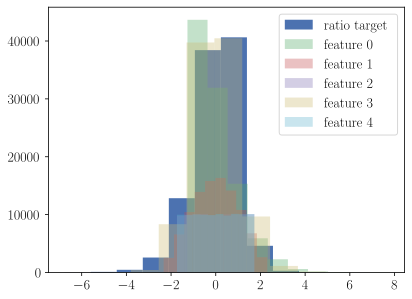

In [57]:
plt.hist(valid_t_ratio, label='ratio target');
for i in range(NFEATURES):
    plt.hist(valid_x[:,i], label =f"feature {i}", alpha=0.35)
plt.legend();plt.show()

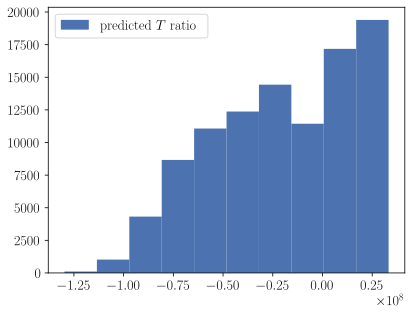

In [58]:
IQN.eval()
valid_x_tensor=torch.from_numpy(valid_x).float()
pred = IQN(valid_x_tensor)
p = pred.detach().numpy()
plt.hist(p, label='predicted $T$ ratio');plt.legend();plt.show()

Apparently it dosn't work, but let's continue.

(we want to see a gaussian-like ratio centered around 0 as in the plots above.)

Recall that $ f_{\text{IQN}} $ estimates:

$$
        f_{\text{IQN}} (\mathcal{O}) =  z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$


So, to de-scale, (for our observable $\mathcal{O}=m$ ),

$$
    m^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 \right]
$$

Note that $z^{-1} (f_{\text{IQN}} )$ should use the mean and std of the ratio thing for the target 

$$z^{-1} (f_{\text{IQN}} ) = z^{-1}\left( y_{pred}, \text{mean}=\text{mean}(\mathbb{T}(\text{target_variable})), std=std (\mathbb{T}(\text{target_variable} ) \right)$$

In [59]:
def get_finite(values):
    return values[np.isfinite(values)]

def z_inverse(xprime, mean, std):
    return xprime * std + mean

In [60]:
recom_unsc_mean=TEST_SCALE_DICT[target]['mean']
recom_unsc_std=TEST_SCALE_DICT[target]['std']
print(recom_unsc_mean,recom_unsc_std)

5.567204865049224 2.6755751570852406


Get unscaled again, just to verify

In [61]:
raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )
raw_test_data.describe()

,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,32.789973,0.006608,0.008208,6.999333,32.911578,0.006592,0.008088,5.567205,0.501150
std,15.384256,2.202526,1.813943,2.848071,15.987607,2.196239,1.814262,2.675589,0.288991
min,20.000500,-5.129500,-3.141580,-0.000043,11.475300,-4.995010,-3.451545,-0.000037,0.000013
25%,23.746000,-1.644760,-1.568913,5.129663,23.492925,-1.638462,-1.567520,3.811640,0.250567
50%,28.415000,0.022204,0.007787,6.555330,29.040850,0.024047,0.008805,5.129005,0.501971
75%,36.405900,1.652347,1.581260,8.317600,37.637800,1.648130,1.581675,6.785560,0.752653
max,414.323000,5.085910,3.141460,71.779900,399.330000,4.994290,3.462845,70.626900,0.999996


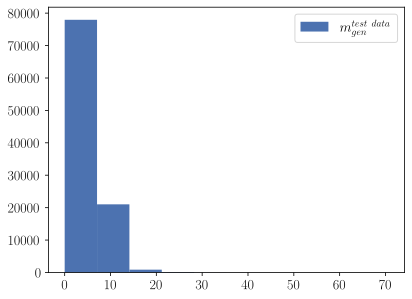

In [64]:
m_reco = raw_test_data['RecoDatam']
m_gen = raw_test_data['genDatam']
plt.hist(m_reco,label=r'$m_{gen}^{test \ data}$');plt.legend();plt.show()



Apply the descaling formula for our observable

$$
    m^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 \right]
$$

First, calculate $z^{-1} (f_{\text{IQN}} )$

In [65]:
print(valid_t_ratio.shape, valid_t_ratio[:5])

(100000,) [0.48751998 0.46176516 0.46176516 0.46176516 0.10816024]


In [66]:
z_inv_f =z_inverse(xprime=p, mean=np.mean(valid_t_ratio), std=np.std(valid_t_ratio))
z_inv_f[:5]

array([[-36455216.],
       [ 18558738.],
       [ 19250840.],
       [-60801076.],
       [-24907742.]], dtype=float32)


$$\mathbb{L}(\mathcal{O^{\text{gen}}}) = L (m^{\text{gen}})$$


In [68]:
L_obs = L(orig_observable=m_gen, label='m')
L_obs[:5]

array([2.07104388, 2.07104388, 2.24205984, 2.28661525, 1.97173801])

In [69]:
print(L_obs.shape, z_inv_f.shape)

(100000,) (100000, 1)


In [70]:
z_inv_f = z_inv_f.flatten();print(z_inv_f.shape)

(100000,)


"factor" $ = z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 $

In [71]:
factor = (z_inv_f * (L_obs  + 10) )-10
factor[:5]

array([-4.40052522e+08,  2.24023331e+08,  2.35669925e+08, -7.47039438e+08,
       -2.98188972e+08])

In [72]:
pT_pred = L_inverse(L_observable=factor, label='m')
# pT_pred=get_finite(pT_pred)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [73]:
pT_pred

array([-2., inf, inf, ..., -2., inf, -2.])

In [74]:
pT_pred=get_finite(pT_pred)
pT_pred

array([-2., -2., -2., ..., -2., -2., -2.])

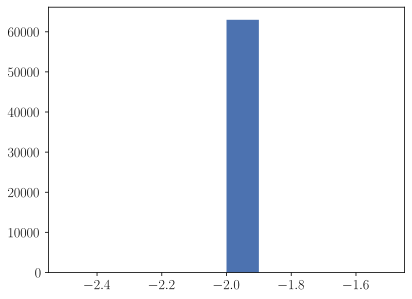

In [75]:
plt.hist(pT_pred.flatten());plt.show()

# Notebook attempting to do this scaling is over (results are weird)
-------------------


Makes no sense to include my tuning codes or train for longer time/datasets or make it more user-friendly since results are so off. 

----

Still some more experimentation below

In [152]:
print(f'spliting data for {target}')
train_t, train_x = normal_split_t_x(df= train_data_m, target = target, input_features=features)
print('train_t shape = ',train_t.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t, valid_x = normal_split_t_x(df= test_data_m, target = target, input_features=features)
print('valid_t shape = ',valid_t.shape , 'valid_x shape = ', valid_x.shape)

print('no need to train_test_split since we already have the split dataframes')

spliting data for RecoDatam
train_t shape =  (10000,) train_x shape =  (10000, 5)

 Training features:

[[ 3.38253091  0.828187    2.90213     1.57969597 -0.83214275]
 [ 3.19127027 -1.16351     0.636469    2.05883697 -2.23860448]
 [ 3.19127027 -1.16351     0.636469    2.05883697  2.77384086]
 ...
 [ 3.58368281  3.537       3.1117      2.26299775 -1.15418175]
 [ 3.58368281  3.537       3.1117      2.26299775  2.00190305]
 [ 3.44642884  2.70158     0.267685    2.41813007  2.39480772]]
valid_t shape =  (10000,) valid_x shape =  (10000, 5)
no need to train_test_split since we already have the split dataframes


[3.43200706 0.03296074 0.02674094 2.15370158 0.04535625] [0.34109032 2.21113156 1.81910579 0.28837389 1.74437024]
[ 3.42368585 -0.00716868  0.00421532  2.15308963  0.00824955] [0.33548512 2.20977298 1.80908512 0.28603437 1.7285385 ]



1.9674994396477465 0.32899204139494215
1.9649797331536134 0.3264556967084843


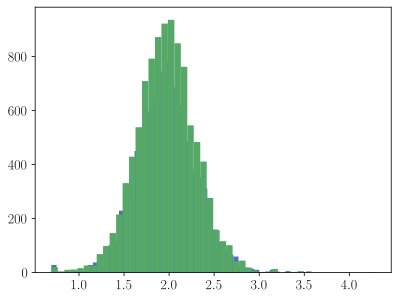

In [148]:
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print('\n\n')
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
plt.hist(train_t, bins=50);plt.hist(valid_t,bins=50);plt.show()

Training for 20000 iterations
estimating RecoDatam

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.215092	  0.288486
     19950	-784456.312500	-773300.125000	-690390.937500


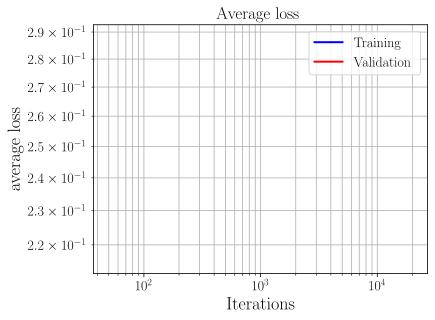

evaluating m took  21.789092540740967 seconds


In [149]:
n_iterations, n_layers, n_hidden, starting_learning_rate, dropout = get_model_params()
def load_untrained_model():
    NFEATURES=train_x.shape[1]
    model=RegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
                               nlayers=n_layers, hidden_size=n_hidden, dropout=dropout)
    return model

model=load_untrained_model()

print(f'Training for {n_iterations} iterations')
start=time.time()
print('estimating %s\n' % target)
IQN_trace=([], [], [], [])
traces_step = 50
n_iterations=20000
IQN = run(model=model, target=target,train_x=train_x, train_t=train_t, 
        valid_x=valid_x, valid_t=valid_t, traces=IQN_trace, n_batch=2560, 
        n_iterations=n_iterations, traces_step=50, traces_window=50,
        save_model=False)

end=time.time()
difference=end-start
print('evaluating m took ',difference, 'seconds')

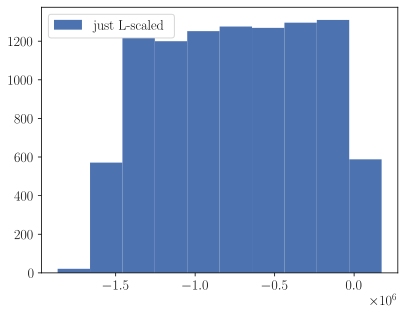

In [150]:
def simple_eval(model):
    model.eval()
    valid_x_tensor=torch.from_numpy(valid_x).float()
    pred = IQN(valid_x_tensor)
    p = pred.detach().numpy()
    plt.hist(p, label='just L-scaled');plt.legend();plt.show()
    
simple_eval(IQN)

spliting data for RecoDatam
train_t shape =  (10000,) train_x shape =  (10000, 5)

 Training features:

[[29.4452      0.828187    2.90213     2.85348     0.36130954]
 [24.3193     -1.16351     0.636469    5.83685     0.12689925]
 [24.3193     -1.16351     0.636469    5.83685     0.96230681]
 ...
 [36.0059      3.537       3.1117      7.61186     0.30763637]
 [36.0059      3.537       3.1117      7.61186     0.83365051]
 [31.3881      2.70158     0.267685    9.22485     0.89913462]]
valid_t shape =  (10000,) valid_x shape =  (10000, 5)
no need to train_test_split since we already have the split dataframes


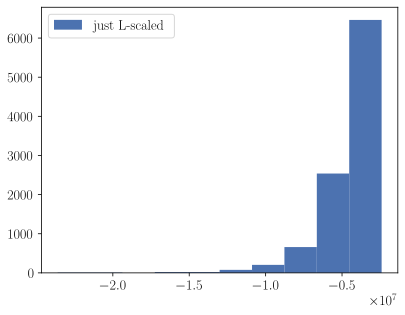

In [156]:
print(f'spliting data for {target}')
train_t, train_x = normal_split_t_x(df= train_data, target = target, input_features=features)
print('train_t shape = ',train_t.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t, valid_x = normal_split_t_x(df= train_data, target = target, input_features=features)
print('valid_t shape = ',valid_t.shape , 'valid_x shape = ', valid_x.shape)

print('no need to train_test_split since we already have the split dataframes')
simple_eval(IQN)

### Evalute model and save evaluated data

In [137]:
if target== 'RecoDatapT':
    label= '$p_T$ [GeV]'
    x_min, x_max = 20, 60
elif target== 'RecoDataeta':
    label = '$\eta$'
    x_min, x_max = -5.4, 5.4
elif target =='RecoDataphi':
    label='$\phi$'
    x_min, x_max = -3.4, 3.4
elif target == 'RecoDatam':
    label = ' $m$ [GeV]'
    x_min, x_max = 0, 18


    
def evaluate_model(dnn, target, src,
               fgsize=(6, 6), 
               ftsize=20,save_image=False, save_pred=False,
               show_plot=True):
    eval_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'))
    ev_features=X
    #['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','tau']
    
    eval_data=eval_data[ev_features]
    
    print('EVALUATION DATA OLD INDEX\n', eval_data.head())

    

                            
    dnn.eval()
    y = dnn(eval_data)
    eval_data['RecoDatam']=y
    new_cols= ['RecoDatam'] + X
    eval_data=eval_data.reindex(columns=new_cols)
    print('EVALUATION DATA NEW INDEX\n', eval_data.head())

    eval_data.to_csv('AUTOREGRESSIVE_m_Prime.csv')


    if save_pred:
        pred_df = pd.DataFrame({T+'_predicted':y})
        pred_df.to_csv('predicted_data/dataset2/'+T+'_predicted_MLP_iter_5000000.csv')
        
    if save_image or show_plot:
        gfile ='fig_model_%s.png' % target
        xbins = 100
        xmin  = src['xmin']
        xmax  = src['xmax']
        xlabel= src['xlabel']
        xstep = (xmax - xmin)/xbins

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
        
        ax.set_xlim(xmin, xmax)
        ax.set_xlabel(xlabel, fontsize=ftsize)
        ax.set_xlabel('reco jet '+label, fontsize=ftsize)
        ax.set_ylabel(y_label_dict[target], fontsize=ftsize)

        ax.hist(train_data['RecoDatam'], 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='blue', 
                density=True, 
                label='simulation')
        ax.hist(y, 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='red', 
                density=True, 
                label='$y^\prime$')
        ax.grid()
        ax.legend()
        
        
        if save_image:
            plt.savefig('images/'+T+'IQN_Consecutive_'+N+'.png')
            print('images/'+T+'IQN_Consecutive_'+N+'.png')
        if show_plot:
            plt.tight_layout()
            plt.show()
##########
################################################CNN







def main():
    start=time.time()
    print('estimating mass\n')
    model =  utils.RegularizedRegressionModel(nfeatures=train_x.shape[1], ntargets=1,nlayers=n_layers, hidden_size=n_hidden)
    traces = ([], [], [], [])
    dnn = run(model, scalers, target, train_x, train_t, valid_x, valid_t, traces)
    evaluate_model( dnn, target, source)



if __name__ == "__main__":
    main()



estimating mass



NameError: name 'scalers' is not defined

# Plot predicted vs real reco (in our paper's format)

# Train $p_T$ using saved variables above

Evaluate $p_T$ and save predicted distribution

Plot reco $p_T$ and  predicted reco $p_T$ marginal densities

In [155]:
# show_jupyter_image('screenshot.png')

<!-- > I guess it works now -->

commented new ideas below

<!-- ### Ideas for a future paper

me and Harrison would like to use this method for on-the-fly stochastic folding of events in MC generators (potentially even including CMSSW formats like [nanoaod](https://github.com/cms-nanoAOD/nanoAOD-tools), such as in Madminer (but using IQN as opposed to Delphes for detector simulation) for any observable. This also beings the possibility of using LFI methods for much better inference on models (such as SMEFT) using any observable post-detector simulation. If you're interested in helping out on this, me and Harrison would like to do most of the code/ideas, but your occasional ideas/input would be incredibly valuable! -->